In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from airsenal.framework.schema import Fixture, Player, PlayerPrediction, PlayerScore
from airsenal.framework.utils import session

ImportError: cannot import name 'rerun_predictions' from 'airsenal.scripts.replay_season' (/Users/nbarlow/miniforge3/envs/airsenalenv/lib/python3.9/site-packages/airsenal/scripts/replay_season.py)

## Generate Predictions (slow!)

In [8]:
season = "2021"
gw_start = 4
gw_end = 4

weeks_ahead = 9
num_thread = 1

Run outside this notebook:
```
rerun_predictions(
    season=season,
    gw_start=gw_start,
    gw_end=gw_end,
    weeks_ahead=weeks_ahead, 
    num_thread=num_thread,
)
```

## Get Players from Database

In [9]:
players = pd.read_sql(session.query(Player).statement, session.bind)
players.set_index("player_id", inplace=True)
players = players["name"]
players.head()

player_id
1                    Mesut Özil
2     Sokratis Papastathopoulos
3    David Luiz Moreira Marinho
4     Pierre-Emerick Aubameyang
5                 Cédric Soares
Name: name, dtype: object

## Get Predictions from the Database

In [10]:
gw = 4

In [11]:
preds = pd.read_sql(session.query(PlayerPrediction).statement, session.bind)

tags = preds["tag"].unique().astype(str)
tags

array(['655335dc-2e34-46b5-a068-92bd5eb2b772',
       '2021_5_3254e096-fbf4-4239-a5a9-c88e311d4e63',
       '2021_6_08d61018-a892-44b4-87dd-f40228396e70',
       '2021_7_cb7e3e71-45ae-45ad-bc2e-a0fbae33875a',
       '2021_8_f1772fa2-3fd7-41d2-a85b-168018040625',
       '2021_9_272114e3-a989-45c6-baa2-35ef78429c8c',
       '2021_4_e3fb1857-9eb6-4e3d-9628-095e9dc9bd31'], dtype='<U43')

In [12]:
gw_tag = tags[np.char.startswith(tags, f"{season}_{gw}_")][0]

gw_preds = preds[preds["tag"] == gw_tag]
gw_preds.head()

id  fixture_id  predicted_points  \
11886  11887        1181          4.113708   
11887  11888        1182          3.761504   
11888  11889        1196          4.609765   
11889  11890        1205          4.103372   
11890  11891        1220          2.536095   

                                               tag  player_id  
11886  2021_4_e3fb1857-9eb6-4e3d-9628-095e9dc9bd31        317  
11887  2021_4_e3fb1857-9eb6-4e3d-9628-095e9dc9bd31        317  
11888  2021_4_e3fb1857-9eb6-4e3d-9628-095e9dc9bd31        317  
11889  2021_4_e3fb1857-9eb6-4e3d-9628-095e9dc9bd31        317  
11890  2021_4_e3fb1857-9eb6-4e3d-9628-095e9dc9bd31        317

In [13]:
tags

array(['655335dc-2e34-46b5-a068-92bd5eb2b772',
       '2021_5_3254e096-fbf4-4239-a5a9-c88e311d4e63',
       '2021_6_08d61018-a892-44b4-87dd-f40228396e70',
       '2021_7_cb7e3e71-45ae-45ad-bc2e-a0fbae33875a',
       '2021_8_f1772fa2-3fd7-41d2-a85b-168018040625',
       '2021_9_272114e3-a989-45c6-baa2-35ef78429c8c',
       '2021_4_e3fb1857-9eb6-4e3d-9628-095e9dc9bd31'], dtype='<U43')

## Get Actual Scores from the Database

In [14]:
query = (
    session.query(PlayerScore, Fixture.season, Fixture.gameweek)
    .filter(Fixture.gameweek >= gw)
    .filter(Fixture.gameweek < gw + weeks_ahead)
    .filter(Fixture.season == season)
    .join(Fixture)
)
scores = pd.read_sql(query.statement, session.bind)
scores.set_index("id", inplace=True, drop=True)
scores = scores.merge(players, left_on="player_id", right_index=True)

scores.head()

player_team opponent  points  goals  assists  bonus  conceded  minutes  \
id                                                                             
66725         ARS      SHU       0      0        0      0         0        0   
66726         ARS      MCI       0      0        0      0         0        0   
66727         ARS      LEI       0      0        0      0         0        0   
66728         ARS      MUN       0      0        0      0         0        0   
66729         ARS      AVL       0      0        0      0         0        0   

       player_id  result_id  ...  red_cards  saves  bps  influence  \
id                           ...                                     
66725          1       1175  ...          0      0    0        0.0   
66726          1       1181  ...          0      0    0        0.0   
66727          1       1196  ...          0      0    0        0.0   
66728          1       1205  ...          0      0    0        0.0   
66729          1       1218  ...          0      0    0        0.0   

       creativity  threat  ict_index  season  gameweek        name  
id                                                                  
66725         0.0     0.0        0.0    2021         4  Mesut Özil  
66726         0.0     0.0        0.0    2021         5  Mesut Özil  
66727         0.0     0.0        0.0    2021         6  Mesut Özil  
66728         0.0     0.0        0.0    2021         7  Mesut Özil  
66729         0.0     0.0        0.0    2021         8  Mesut Özil  

[5 rows x 26 columns]

In [15]:
scores[["name", "points"]].sort_values(by="points", ascending=False).head()

name  points
id                            
67214    Jack Grealish      24
70606     Riyad Mahrez      21
67395    Ollie Watkins      19
69036  James Rodríguez      18
72251    Heung-Min Son      18

In [16]:
scores = scores.merge(
    gw_preds, left_on=["player_id", "fixture_id"], right_on=["player_id", "fixture_id"]
)

scores.head()

player_team opponent  points  goals  assists  bonus  conceded  minutes  \
0         ARS      SHU       0      0        0      0         0        0   
1         ARS      MCI       0      0        0      0         0        0   
2         ARS      LEI       0      0        0      0         0        0   
3         ARS      MUN       0      0        0      0         0        0   
4         ARS      AVL       0      0        0      0         0        0   

   player_id  result_id  ...  influence  creativity  threat  ict_index  \
0          1       1175  ...        0.0         0.0     0.0        0.0   
1          1       1181  ...        0.0         0.0     0.0        0.0   
2          1       1196  ...        0.0         0.0     0.0        0.0   
3          1       1205  ...        0.0         0.0     0.0        0.0   
4          1       1218  ...        0.0         0.0     0.0        0.0   

   season  gameweek        name     id  predicted_points  \
0    2021         4  Mesut Özil  13282               0.0   
1    2021         5  Mesut Özil  13283               0.0   
2    2021         6  Mesut Özil  13284               0.0   
3    2021         7  Mesut Özil  13285               0.0   
4    2021         8  Mesut Özil  13286               0.0   

                                           tag  
0  2021_4_e3fb1857-9eb6-4e3d-9628-095e9dc9bd31  
1  2021_4_e3fb1857-9eb6-4e3d-9628-095e9dc9bd31  
2  2021_4_e3fb1857-9eb6-4e3d-9628-095e9dc9bd31  
3  2021_4_e3fb1857-9eb6-4e3d-9628-095e9dc9bd31  
4  2021_4_e3fb1857-9eb6-4e3d-9628-095e9dc9bd31  

[5 rows x 29 columns]

Text(0.5, 1.0, '2021 GW 4 - GW 12')

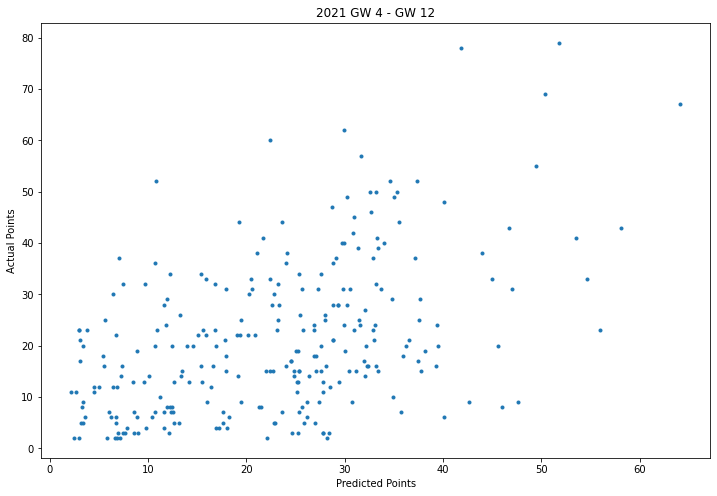

In [17]:
sum_pts = scores.groupby("name")[["points", "predicted_points"]].sum()

mask = (sum_pts["points"] > 1) & (sum_pts["predicted_points"] > 1)

plt.figure(figsize=(12, 8))
plt.plot(sum_pts[mask]["predicted_points"], sum_pts[mask]["points"], ".")
plt.xlabel("Predicted Points")
plt.ylabel("Actual Points")
plt.title(f"{season} GW {gw} - GW {gw + weeks_ahead - 1}")

In [18]:
sum_pts.corr()

points  predicted_points
points            1.000000          0.609705
predicted_points  0.609705          1.000000

In [20]:
sum_pts[mask].sort_values(by="points", ascending=False).head(30)

points  predicted_points
name                                                   
Harry Kane                         79         51.757249
Heung-Min Son                      78         41.799448
Bruno Miguel Borges Fernandes      69         50.329938
Mohamed Salah                      67         64.106293
Jack Grealish                      62         29.925376
Kurt Zouma                         60         22.363542
James Ward-Prowse                  57         31.714941
Jamie Vardy                        55         49.436771
Che Adams                          52         34.611957
Jannik Vestergaard                 52         10.856791
Dominic Calvert-Lewin              52         37.391547
Nick Pope                          50         32.610420
Wilfried Zaha                      50         35.351171
Callum Wilson                      50         33.207935
Hugo Lloris                        49         35.019067
Lukasz Fabianski                   49         30.228355
Timo Werner                        48         40.128369
Ollie Watkins                      47         28.717096
Patrick Bamford                    46         32.716847
Pedro Lomba Neto                   45         30.994798
Kyle Walker                        44         35.497687
Jan Bednarek                       44         19.301998
Aaron Cresswell                    44         23.620317
Raheem Sterling                    43         58.071351
Marcus Rashford                    43         46.692721
Alex McCarthy                      42         30.808548
Ederson Santana de Moraes          41         33.292299
Angelo Ogbonna                     41         21.658256
Kevin De Bruyne                    41         53.555860
Pablo Fornals                      40         29.727151